<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/Kopia_notatnika_DUDL_metaparams_CodeChallengeRelus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook I learn about the importance of balancing the data. The fact that our model reaches 100% accuracy doesn't always indicate a success :(.

Even though 1st and 3rd model reach decent test accuracy, they are most likely to mislabel the wine which occurs less in the data.

In [38]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [39]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')

# drop a few outliers
data = data[data['total sulfur dioxide']<200]

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Re-organize the data: train/test in DataLoaders

In [40]:
def getData(threshold):
    # create a new column for binarized (boolean) quality
    data['boolQuality'] = 0
    data['boolQuality'][data['quality'] > threshold] = 1

    # convert from pandas dataframe to tensor
    dataT  = torch.tensor( data[cols2zscore].values ).float()
    labels = torch.tensor( data['boolQuality'].values ).float()
    labels = labels[:,None]

    # use scikitlearn to split the data
    train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = torch.utils.data.TensorDataset(train_data,train_labels)
    test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

    # finally, translate into dataloader objects
    batchsize    = 8
    train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
    test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

    return train_loader, test_loader

# Now for the DL part

In [41]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)

    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun

  # forward pass
  def forward(self,x):
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

# Train the model

In [42]:
# a function that trains the model

# global parameter
numepochs = 700

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

<ipython-input-40-cd9942d5ebf7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality'] > threshold] = 1
<ipython-input-40-cd9942d5ebf7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality'] > threshold] = 1
<ipython-input-40-cd9942d5ebf7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality'] > threshold] = 1


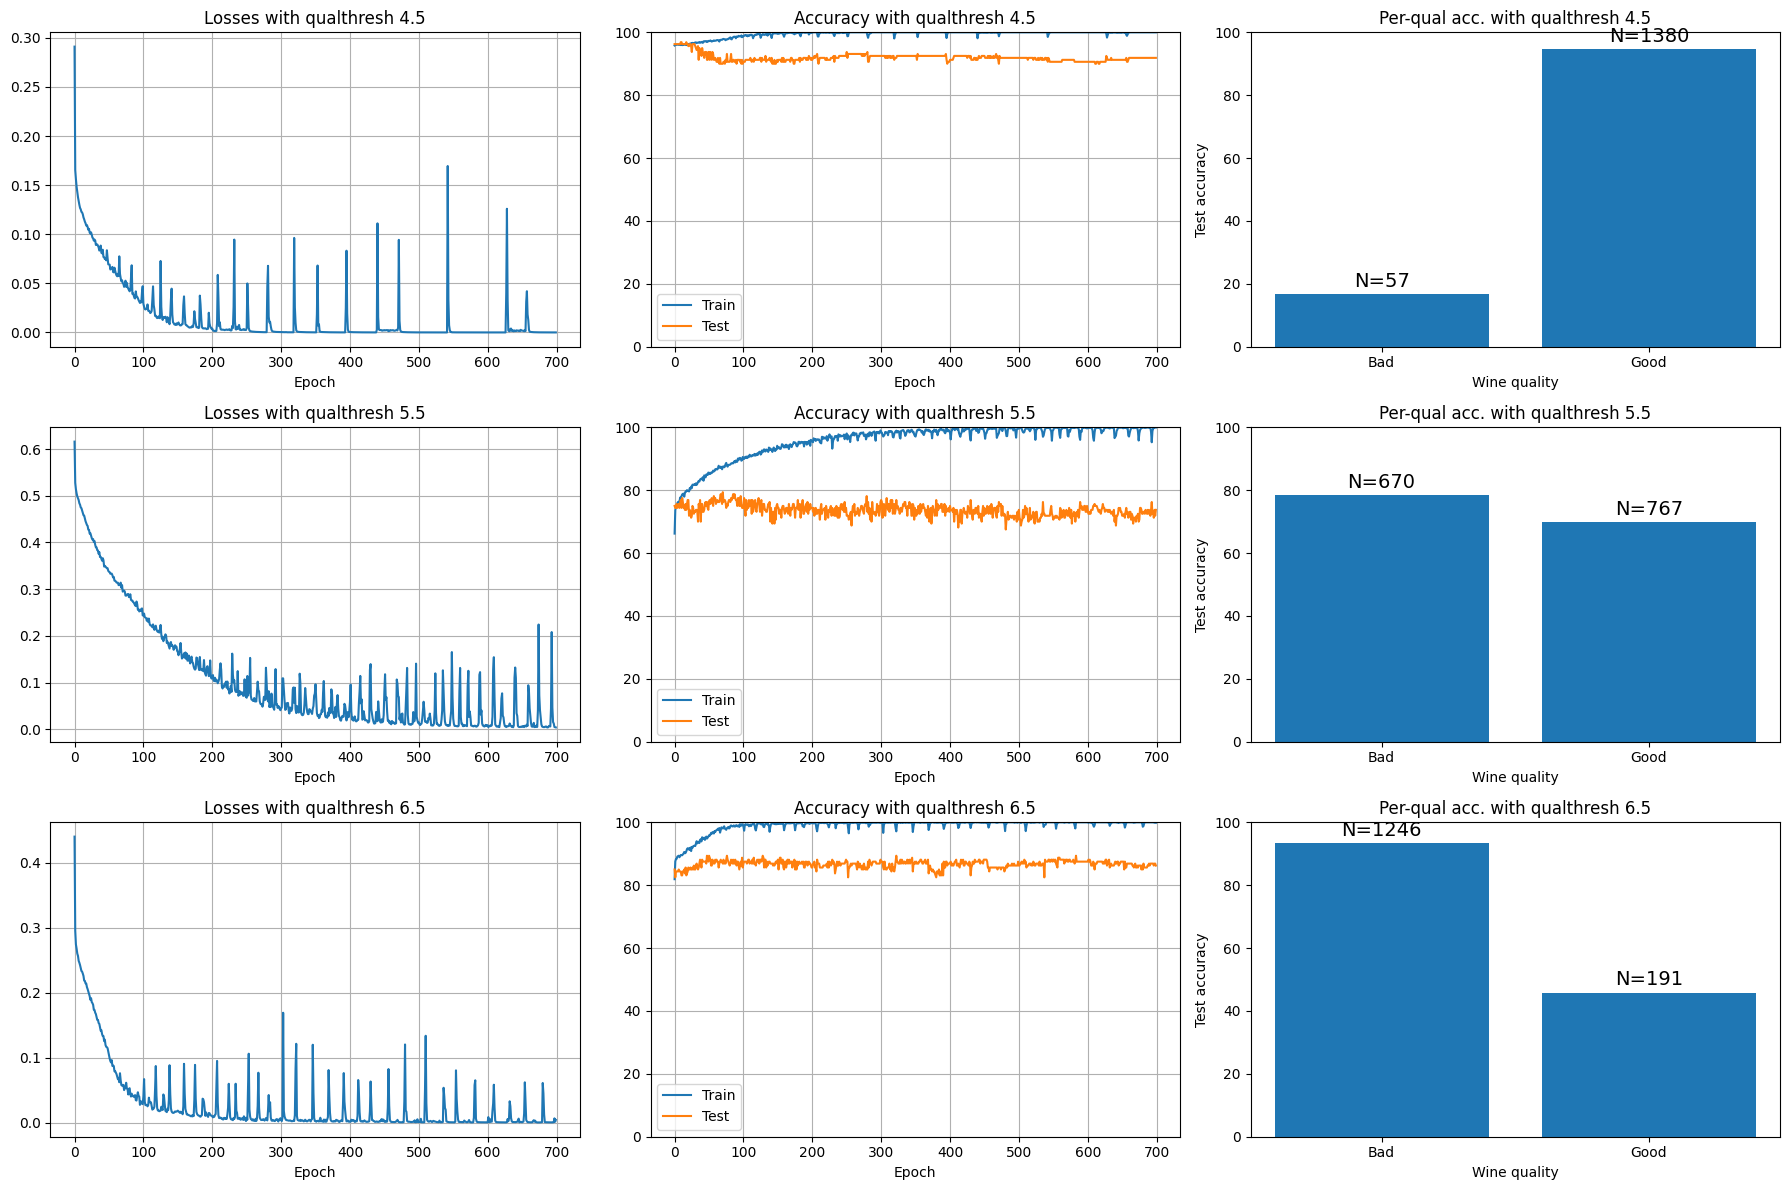

In [43]:
# note: this cell takes around 5 mins

# setup the figure
fig,ax = plt.subplots(3,3,figsize=(18,12))

# the quality thresholds
qualityThresholds = [4,5,6]


# loop over quality thresholds
for quali in range(len(qualityThresholds)):

  # create the data and model, and train it
  train_loader,test_loader = getData( qualityThresholds[quali] )
  winenet = ANNwine('LeakyReLU')
  trainAcc,testAcc,losses = trainTheModel()

  # compute accuracy per quality type
  X,y = next(iter(test_loader))
  itemAccuracy = ((winenet(X)>0) == y).float()
  perQualAcc  = [ 100*torch.mean(itemAccuracy[y==0]) ,
                  100*torch.mean(itemAccuracy[y==1]) ]


  # plot losses
  ax[quali,0].plot(losses)
  ax[quali,0].set_title('Losses with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,0].set_xlabel('Epoch')
  ax[quali,0].grid()

  # plot overall accuracy
  ax[quali,1].plot(trainAcc,label='Train')
  ax[quali,1].plot(testAcc,label='Test')
  ax[quali,1].set_title('Accuracy with qualthresh ' + str(qualityThresholds[quali]+.5))
  ax[quali,1].legend()
  ax[quali,1].set_xlabel('Epoch')
  ax[quali,1].set_ylim([0,100])
  ax[quali,1].grid()

  # plot the per-quality accuracy
  bh = ax[quali,2].bar(['Bad','Good'],perQualAcc)
  ax[quali,2].set_ylim([0,100])
  ax[quali,2].set_xlabel('Wine quality')
  ax[quali,2].set_ylabel('Test accuracy')
  ax[quali,2].set_title('Per-qual acc. with qualthresh ' + str(qualityThresholds[quali]+.5))

  # print the counts on top of each bar
  for i,r in enumerate(bh):
    N = torch.sum(train_loader.dataset.tensors[1]==i).item()
    ax[quali,2].text(r.get_x()+r.get_width()/2, r.get_height()+1,
              'N=%s'%N, ha='center', va='bottom', fontsize=14)


plt.tight_layout()
plt.show()